In [1]:
# test gemini api

from google import genai

from dotenv import load_dotenv
import os
load_dotenv()

client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

response = client.models.generate_content(
    model="gemini-2.5-flash-lite",
    contents="Hello, how are you?",
)

print(response.text)

Hello! I'm doing well, thank you for asking. I'm a large language model, so I don't experience feelings in the same way humans do, but I'm functioning optimally and ready to assist you.

How are you doing today? Is there anything I can help you with?


In [2]:
# initialize langsmith tracing
from langchain_google_genai import ChatGoogleGenerativeAI

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "CSE-291-GEO"


query_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

query_model.invoke("Hello, how are you?")

AIMessage(content="I'm doing great, thank you for asking! I'm a large language model, so I don't experience feelings in the same way humans do, but I'm functioning optimally and ready to help you with whatever you need.\n\nHow are **you** doing today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--dba1d5a0-e56b-4712-8097-6db60dfbad42-0', usage_metadata={'input_tokens': 7, 'output_tokens': 58, 'total_tokens': 65, 'input_token_details': {'cache_read': 0}})

In [3]:
from typing import Dict, Any, List
from pprint import pprint

def make_initial_state(doc: str) -> Dict[str, Any]:
    """
    Create the initial pipeline state.
    We only know the source document now.
    """
    return {
        "doc": doc,               # current document (D0)
        "benchmark": None,        # Our document and competing documents
        "eval_result": None,      # Evaluation results
        "edit_instruction": None, # Edit instruction
        "edited_doc": None,       # Revised document
    }

In [4]:
import os
import requests
from typing import List

def tavily_retrieve(query: str, max_results: int = 3) -> List[str]:
    """
    Retrieve context snippets from Tavily Search API.

    Args:
        query (str): Search query to retrieve information for.
        max_results (int): Number of search snippets to return (default=5).

    Returns:
        List[str]: A list of text snippets relevant to the query.
    
    Notes:
        - Requires an environment variable `TAVILY_API_KEY`.
        - If the request fails or key is missing, returns an empty list.
    """
    api_key = os.getenv("TAVILY_API_KEY")
    if not api_key:
        print("[WARN] Missing TAVILY_API_KEY in environment — returning empty context list.")
        return []

    url = "https://api.tavily.com/search"
    payload = {
        "api_key": api_key,
        "query": query,
        "max_results": max_results
    }

    try:
        response = requests.post(url, json=payload, timeout=15)
        response.raise_for_status()
        data = response.json()

        # Tavily returns results under `results`, each item may contain `content` or `snippet`
        results = data.get("results", [])
        contexts = [
            item.get("content") or item.get("snippet") or ""
            for item in results
        ]
        return [ctx for ctx in contexts if ctx][:max_results]

    except requests.exceptions.RequestException as e:
        print(f"[WARN] Tavily request failed: {e}")
        return []


In [5]:
# --- Query node (step 1) ---

QUERY_SYSTEM_PROMPT = """
You are a query generation agent for a multi-agent content optimization pipeline.

You will be given ONE document.
Your task is to propose 3 realistic user queries that a generative search engine might ask about this document.
Return ONLY a JSON object with one field "queries", which is an array of strings.
Example:
{"queries": ["...", "...", "..."]}
"""


def query_node(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    1. Read state["doc"]
    2. Ask LLM to generate 3-5 queries about this doc
    3. For each query, retrieve contexts (currently fake)
    4. Write into state["benchmark"]
    """
    doc = state["doc"]

    # 1) call LLM to get queries
    user_msg = f"Here is the document:\n\n{doc}\n\nPlease generate the queries."
    messages = [
        {"role": "system", "content": QUERY_SYSTEM_PROMPT},
        {"role": "user", "content": user_msg},
    ]
    llm_resp = query_model.invoke(messages)
    raw = llm_resp.content

    # 2) try to parse JSON safely
    #    sometimes model will wrap in codeblock, we handle that quickly
    import json, re
    try:
        # remove ```json ... ``` if present
        raw_clean = re.sub(r"```json|```", "", raw).strip()
        data = json.loads(raw_clean)
        queries = data.get("queries", [])
    except Exception:
        print(f"Error parsing JSON: {raw}")
        # fallback: if model didn't follow schema, just make 3 generic queries
        queries = [
            "What is the main topic of this document?",
            "What are the key components discussed in this document?",
            "How can the method in this document be applied?"
        ]

    # 3) retrieve contexts for each query
    benchmark: List[Dict[str, Any]] = []
    for q in queries:
        ctx = tavily_retrieve(q)  # <--- replace with your real tool here
        benchmark.append(
            {
                "query": q,
                "contexts": ctx,
            }
        )

    # 4) write back
    state["benchmark"] = benchmark
    return state


In [6]:
# --- Evaluator node (step 2) ---
import json
evaluator_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

EVAL_SYSTEM_PROMPT = """
You are an evaluator in a multi-agent content optimization pipeline.

Your task:
Given (1) a user question, (2) a candidate document (the one we want to optimize),
and (3) several other retrieved contexts (possible competing sources),
you must:
1. Answer the question using ALL provided content.
2. Then rate the candidate document ONLY on the following 6 metrics:

- CP (Citation Prominence): did the answer explicitly or implicitly cite/use the candidate?
- AA (Attribution Accuracy): are statements attributed to the candidate actually in the candidate?
- FA (Faithfulness): did we avoid fabricating or distorting what the candidate said?
- KC (Key Information Coverage): does the candidate contain the key info needed to answer this question?
- SC (Semantic Contribution): how much did the candidate contribute to the final answer vs other contexts?
- AD (Answer Dominance): if a GSE produced this answer, how dominant would this candidate be in that answer?

Score each metric from 0.0 to 1.0.
Return JSON with fields: answer, scores, explanation.
Example:
{
  "answer": "...",
  "scores": {
    "CP": 0.7,
    "AA": 1.0,
    "FA": 1.0,
    "KC": 0.4,
    "SC": 0.5,
    "AD": 0.5
  },
  "explanation": "candidate did not list all API types ..."
}
"""

def evaluator_node(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Evaluate the current document against each (query, contexts) pair in the benchmark.
    Produce per-query results + a summary (avg over 6 metrics).
    """
    doc = state["doc"]
    benchmark: List[Dict[str, Any]] = state["benchmark"] or []

    per_query_results = []
    metric_sums = {
        "CP": 0.0,
        "AA": 0.0,
        "FA": 0.0,
        "KC": 0.0,
        "SC": 0.0,
        "AD": 0.0,
    }
    n = len(benchmark) if benchmark else 1

    for item in benchmark:
        q = item["query"]
        other_ctxs = item["contexts"] or []

        # 1) build a single big context: candidate doc first, then other retrieved contexts
        #    this simulates "we retrieved the candidate together with other web docs"
        joined_context = "\n\n".join(
            ["[CANDIDATE DOC]\n" + doc] + [f"[CTX]\n{c}" for c in other_ctxs]
        )

        user_prompt = (
            f"Question: {q}\n\n"
            f"Contexts (candidate first):\n{joined_context}\n\n"
            "Please answer the question and then rate the candidate document."
        )

        messages = [
            {"role": "system", "content": EVAL_SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ]

        llm_resp = evaluator_model.invoke(messages)
        raw = llm_resp.content

        # 2) try to parse JSON
        try:
            raw_clean = raw.strip().strip("```json").strip("```").strip()
            data = json.loads(raw_clean)
        except Exception:
            # if parsing fails, create a fallback structure
            data = {
                "answer": raw,
                "scores": {
                    "CP": 0.5,
                    "AA": 0.5,
                    "FA": 0.5,
                    "KC": 0.5,
                    "SC": 0.5,
                    "AD": 0.5,
                },
                "explanation": "LLM did not return valid JSON, using fallback scores."
            }

        scores = data.get("scores", {})
        # accumulate for summary
        for k in metric_sums.keys():
            metric_sums[k] += float(scores.get(k, 0.0))

        per_query_results.append(
            {
                "query": q,
                "answer": data.get("answer", ""),
                "scores": scores,
                "explanation": data.get("explanation", ""),
            }
        )

    # 3) build summary (average)
    summary = {k: v / n for k, v in metric_sums.items()}

    state["eval_result"] = {
        "per_query": per_query_results,
        "summary": summary,
    }
    return state


In [7]:
# --- Analyst node step 3 ---
import re

analyst_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

ANALYST_SYSTEM_PROMPT = """
You are an analysis agent in a multi-agent content optimization pipeline.
You will receive:
- the current document
- a summary of 6 evaluation metrics: CP, AA, FA, KC, SC, AD
- per-query evaluation results, including explanations

Your job:
1. Identify the weakest metric (the one with the lowest score).
2. Find an example query where this weakness shows up clearly.
3. Propose ONE concrete edit to the document that would improve this metric.
4. Make the edit specific and actionable (what to add / where to add / how to rephrase).
5. Output JSON:
{
  "target_metric": "...",
  "reason": "...",
  "instruction": "...",
  "location_hint": "..."
}
IMPORTANT: "instruction" MUST describe how to MODIFY THE DOCUMENT (add, expand, clarify, reorganize).
It MUST NOT describe how the LLM should answer.
Keep it short but specific.
"""

def analyst_node(state):
    doc = state["doc"]
    summary = state["eval_result"]["summary"]
    per_query = state["eval_result"]["per_query"]

    weakest_metric = min(summary, key=summary.get)
    worst_item = min(per_query, key=lambda x: x["scores"][weakest_metric])

    prompt = f"""Doc:\n{doc}\n
    Weakest metric: {weakest_metric}
    Worst query: {worst_item['query']}
    Explanation: {worst_item.get('explanation','')}
    Give one edit as JSON {{target_metric, reason, instruction, location_hint}}.
    """

    resp = analyst_model.invoke([{"role": "user", "content": prompt}]).content

    try:
        cleaned = re.sub(r"```json|```", "", resp).strip()
        edit_instruction = json.loads(cleaned)
    except Exception:
        edit_instruction = {"raw_output": resp}
  
    state["edit_instruction"] = edit_instruction
    return state



In [8]:
# --- Editor node step 4 ---

editor_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

EDITOR_SYSTEM_PROMPT = """
You are an editing agent in a multi-agent content optimization pipeline.
You will receive:
- the original document
- a JSON edit instruction produced by an analyst agent

Your task:
- Apply the instruction to the document
- Keep the original tone and structure as much as possible
- Insert new content near the hinted location if available
- Output ONLY the revised document text (no JSON, no explanation)
"""


def editor_node(state):
    doc = state["doc"]
    edit_instruction = state.get("edit_instruction") or {}

    # these keys may or may not exist, so we read them safely
    target_metric = edit_instruction.get("target_metric", "")
    reason = edit_instruction.get("reason", "")
    instruction = edit_instruction.get("instruction", "")
    location_hint = edit_instruction.get("location_hint", "")

    user_prompt = (
        f"Original document:\n{doc}\n\n"
        "Edit instruction (JSON):\n"
        f"{edit_instruction}\n\n"
        "Apply the instruction and output the revised document."
    )

    messages = [
        {"role": "system", "content": EDITOR_SYSTEM_PROMPT},
        {"role": "user", "content": user_prompt},
    ]

    resp = editor_model.invoke(messages).content

    # write back
    state["edited_doc"] = resp
    return state


In [9]:
# --- Build LangGraph ---

from langgraph.graph import StateGraph, END

def build_graph():
    g = StateGraph(dict)

    g.add_node("query", query_node)
    g.add_node("evaluator", evaluator_node)
    g.add_node("analyst", analyst_node)
    g.add_node("editor", editor_node)

    g.set_entry_point("query")
    g.add_edge("query", "evaluator")
    g.add_edge("evaluator", "analyst")
    g.add_edge("analyst", "editor")
    g.add_edge("editor", END)

    return g.compile()

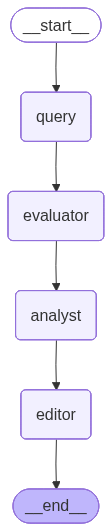

In [10]:
# --- Run once to test ---

app = build_graph()

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
from pprint import pprint

source_doc = """
API (Application Programming Interface) is a set of rules and definitions that allows
applications to communicate with each other. Developers use APIs to access data or
functionality from external services without knowing their internal implementations.
"""

state = make_initial_state(source_doc)
out = app.invoke(state)

for item in out["benchmark"]:
    print({
        "query": item["query"],
        "contexts": item["contexts"]
    })


print("--- eval_result.summary ---")
pprint(out["eval_result"]["summary"])
print("\n--- edit_instruction ---")
pprint(out["edit_instruction"])
print("\n--- edited_doc ---")
print(out["edited_doc"])

{'query': 'what is an API in simple terms?', 'contexts': ['### What is API ? What are the uses of APIs ? We will look at different types of APIs. Also, we will understand what a Client-Server architecture is. ## What is an API ? In simple words, API is an interface that accepts a set of inputs and produces an output. ### APIs over the internet The program running Bob’s machine is known as the server. The contract between the Client and the Server is API. * **Twitter APIs** + People often use Twitter APIs to build bots and automate the process of posting tweets. * **Cloud APIs** In simple words, API is a contract between the client and the server. 1. What is an API ? 3. What is an API ?', "In lay man's terms, an API is the customer service rep that gets you what you need so long as you have some idea what to ask for.", "What is an API?\nMuleSoft Videos\n66000 subscribers\n90923 likes\n5285217 views\n19 Jun 2015\nWant to learn how to build your first API in less than 10 mins? Click here 